In [ ]:
import torch
from algo_reasoning.src.sampler import CLRSDataset
from pathlib import Path
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/miniconda3/envs/algo_reasoning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def homophily_measure(adj_matrix, classes):
    """
    Compute the homophily measure of the graph
    """
    n = adj_matrix.shape[0]
    homophily = 0
    
    for i in range(n):
        node_homophily = 0
        for j in range(n):
            if classes[i] == classes[j]:
                node_homophily += adj_matrix[i, j]

        node_homophily /= adj_matrix[i].sum()
        homophily += node_homophily

    homophily /= n
    return homophily

In [121]:
def unbiased_homophily(adj_matrix, classes):
    """
    Compute the unbiased homophily measure of the graph
    As described in (https://arxiv.org/pdf/2412.09663)
    """
    classes_unique = torch.unique(classes).int()
    n_classes = classes_unique.size(0)
    n_nodes = adj_matrix.size(0)
    n_edges = 0

    class_adj_matrix = torch.zeros(n_classes, n_classes)

    edges_classes = dict()

    for c1 in classes_unique.tolist():
        for c2 in classes_unique.tolist():
            edges_classes[(c1, c2)] = []

    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if adj_matrix[i, j] > 0:
                n_edges += 1
                class_i = classes[i].item()
                class_j = classes[j].item()

                edges_classes[(class_i, class_j)].append((i, j))

    for c1 in classes_unique.tolist():
        for c2 in classes_unique.tolist():
            class_adj_matrix[c1, c2] = len(edges_classes[(c1, c2)]) + len(edges_classes[(c2, c1)])

            if c1 == c2:
                class_adj_matrix[c1, c2] /= n_edges
            else:
                class_adj_matrix[c1, c2] /= 2*n_edges

    numerator = 0
    denominator = 0
    for c1 in classes_unique.tolist():
        filtered_classes = classes_unique[classes_unique > c1].tolist()
        for c2 in filtered_classes:
            numerator += torch.sqrt(class_adj_matrix[c1, c1]*class_adj_matrix[c2, c2]) - class_adj_matrix[c1, c2]
            denominator += torch.sqrt(class_adj_matrix[c1, c1]*class_adj_matrix[c2, c2]) + class_adj_matrix[c1, c2]
   
    return (numerator/denominator).item()

In [149]:
algorithms = ["articulation_points"]

nb_nodes = [4, 7, 11, 13, 16]
batch_size = 128
ds = CLRSDataset(algorithms, nb_nodes, batch_size, 1000, seed=7, algorithms_args={'p': [0.05, 0.1, 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]})

In [150]:
obj = next(iter(ds))

In [151]:
homophilies = [unbiased_homophily(obj.inputs.A[i], obj.outputs.is_cut[i]) for i in range(128) if torch.sum(obj.outputs.is_cut[i]).item() > 0]

In [152]:
homophilies

[-1.0,
 0.45454543828964233,
 -1.0,
 0.4117646813392639,
 -0.18146027624607086,
 -1.0,
 0.5120030641555786,
 -1.0,
 -1.0,
 -0.0051547507755458355,
 0.07179673761129379,
 -1.0,
 0.01405898667871952,
 0.2828596532344818,
 -1.0,
 0.4117647111415863,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.5582714676856995,
 0.35653766989707947,
 -1.0,
 0.4696762263774872,
 0.061636775732040405,
 -0.20000000298023224,
 -1.0,
 -0.1111110970377922,
 -0.0031056294683367014,
 -1.0,
 -1.0,
 -1.0,
 0.3870185911655426,
 0.24040822684764862,
 -1.0,
 -0.0051547507755458355,
 -1.0,
 -1.0,
 -0.20000000298023224,
 0.5194938778877258,
 0.2251482456922531,
 0.35653766989707947,
 -1.0,
 0.2679491639137268,
 -1.0,
 -1.0,
 0.27636757493019104,
 0.35827526450157166,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 0.1219417154788971,
 -1.0,
 -1.0,
 0.06666669994592667,
 -1.0,
 -1.0,
 -1.0,
 0.1665654480457306,
 -1.0,
 0.01405898667871952,
 -1.0,
 -1.0,
 -1.0,
 0.2828596532344818,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.1111110

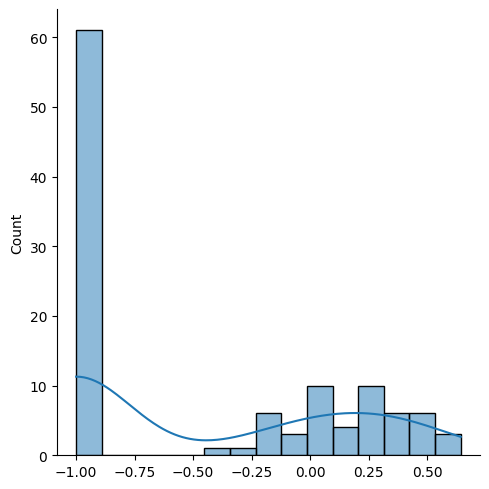

In [153]:
import seaborn as sns

sns.displot(homophilies, kde=True, bins=15)